# Data Preparation

In [22]:
import pandas as pd
import numpy as np
from IPython.display import display

loan_dev = pd.read_csv('data/loan_dev.csv', dtype={'date':object})
loan_comp = pd.read_csv('kaggle/loan_comp.csv', dtype={'date':object}, sep=';')
account = pd.read_csv('data/account.csv', dtype={'date':object})
card_dev = pd.read_csv('data/card_dev.csv', dtype={'issued':object})
card_comp = pd.read_csv('kaggle/card_comp.csv', dtype={'issued':object}, sep=';')
client = pd.read_csv('data/client.csv')
disposition = pd.read_csv('data/disp.csv')
district = pd.read_csv('data/district.csv')
trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})
trans_comp = pd.read_csv('kaggle/trans_comp.csv', dtype={'date':object}, sep=';')

pd.set_option('display.max_columns', None)


/tmp/ipykernel_7591/1998152178.py:13: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans_dev = pd.read_csv('data/trans_dev.csv', dtype={'date':object})


## Loan preparation

In [23]:
loans = pd.concat([loan_dev, loan_comp], ignore_index=True)

loans.rename(columns={'date':'loan_date', 'amount': 'loan_amount', 'duration': 'loan_duration', 'payments': 'loan_payments' }, inplace=True)
loans

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status
0,5314,1787,930705,96396,12,8033,-1.0
1,5316,1801,930711,165960,36,4610,1.0
2,6863,9188,930728,127080,60,2118,1.0
3,5325,1843,930803,105804,36,2939,1.0
4,7240,11013,930906,274740,60,4579,1.0
...,...,...,...,...,...,...,...
677,4989,105,981205,352704,48,7348,NaN
678,5221,1284,981205,52512,12,4376,NaN
679,6402,6922,981206,139488,24,5812,NaN
680,5346,1928,981206,55632,24,2318,NaN


## Account preparation

In [24]:
account.drop(['date'], inplace=True, axis=1)

In [25]:
account.rename(columns={'frequency':'account_frequency', 'district_id': 'account_district_id'}, inplace=True)
account

,account_id,account_district_id,account_frequency
0,576,55,monthly issuance
1,3818,74,monthly issuance
2,704,55,monthly issuance
3,2378,16,monthly issuance
4,2632,24,monthly issuance
...,...,...,...
4495,124,55,monthly issuance
4496,3958,59,monthly issuance
4497,777,30,monthly issuance
4498,1573,63,monthly issuance


## Card preparation

In [26]:
cards = pd.concat([card_dev, card_comp], ignore_index=True)
cards.drop(["issued"], inplace=True, axis=1)
cards = cards.fillna({'type': 'unkown'})

In [27]:
cards.rename(columns={'type':'card_type', 'disp_id': 'card_disp_id'}, inplace=True)
cards

,card_id,card_disp_id,card_type
0,1005,9285,classic
1,104,588,classic
2,747,4915,classic
3,70,439,classic
4,577,3687,classic
...,...,...,...
197,1194,12781,junior
198,17,127,classic
199,623,3984,classic
200,923,7855,classic


## Client preparation

### Extract gender and normalize dates
Since the birth date of each client is represented as YYMMDD when 'Male' or YY(MM+50)DD when 'Female' the gender was extracted as a new feature and the Female client's birth date modified to YYMMDD, the same as Male clients.
Female = False
Male = True

In [28]:
from datetime import datetime, timedelta

def extract_gender(date):
    month = int(str(date)[2:4])
    gender = ''
    if month > 12:
        month -= 50
        gender = 'Female'
    else: 
        gender = 'Male'
    new_date = str(date)[:2] + str(month).zfill(2) + str(date)[4:]
    return (new_date, gender)

In [29]:
genders = []
dates = []

for birth_number in client['birth_number']:
    (new_date, gender) = extract_gender(birth_number)
    dates.append(new_date)
    genders.append(gender)

client['birth_number'] = dates
client['gender'] = genders

In [30]:
client.rename(columns={'district_id': 'client_district_id'}, inplace=True)
client

,client_id,birth_number,client_district_id,gender
0,1,701213,18,Female
1,2,450204,1,Male
2,3,401009,1,Female
3,4,561201,5,Male
4,5,600703,5,Female
...,...,...,...,...
5364,13955,451030,1,Female
5365,13956,430406,1,Male
5366,13968,680413,61,Male
5367,13971,621019,67,Female


## Disposition preparation

### Remove disponent clients and add to the account's owner entry
Without this chenage more than one client were associated to a single account_id. This was a problem when merging Dispositions Loans tables since this would lead to several entries with the same loan_id and target classes replicated.

In [31]:
disp_owners = disposition.loc[disposition['type'] == 'OWNER'].copy()
disp_disponent = disposition.loc[disposition['type'] == 'DISPONENT'].copy()

has_disponent = [id in disp_disponent['account_id'].values for id in disp_owners['account_id'].values]

disp_owners['has_disponent'] = has_disponent
disp_owners.drop('type', inplace=True, axis=1)
display(disp_owners)

,disp_id,client_id,account_id,has_disponent
0,1,1,1,False
1,2,2,2,True
3,4,4,3,True
5,6,6,4,False
6,7,7,5,False
...,...,...,...,...
5363,13623,13931,11333,False
5364,13647,13955,11349,True
5366,13660,13968,11359,False
5367,13663,13971,11362,False


## District preparation

### Clean missing values

There was a row with missing values '?' in the district table for both "no. of commited crimes '95" and "unemploymant rate '95" columns. We needed to find a value for it, either replacing it with median or mean value of the column. To decide between median or mean, we need to analyse symmetry and the outliers of each column.

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa7591bb6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa7591bbc40>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa7591bb3d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa759190220>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa7591904f0>],
 'means': []}

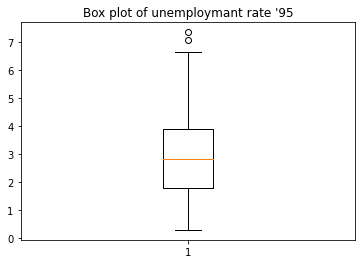

In [32]:
import matplotlib.pyplot as plt

district_clean = district.loc[(district["unemploymant rate '95"] != '?') & (district["no. of commited crimes '95"] != '?')]


plt.title("Box plot of unemploymant rate '95")
plt.boxplot(district_clean["unemploymant rate '95"].astype('float'))

{'whiskers': [<matplotlib.lines.Line2D at 0x7fa7549de290>,
 'caps': [<matplotlib.lines.Line2D at 0x7fa7549de740>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fa7549de020>],
 'medians': [<matplotlib.lines.Line2D at 0x7fa7549dece0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fa7549defb0>],
 'means': []}

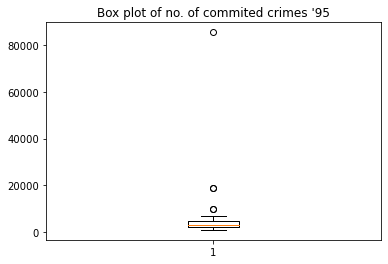

In [33]:
plt.title("Box plot of no. of commited crimes '95")
plt.boxplot(district_clean["no. of commited crimes '95"].astype('int'))

By analysing the box plots, we found out that the data values for "no. of commited crimes '95" and "unemploymant rate '95" are not symmetrical and there are outliers, therefore is would be best to use median instead of mean to replace the cells with '?'

In [34]:

median_unemploymant = district_clean["unemploymant rate '95"].astype(float).median()
median_commited_crimes = district_clean["no. of commited crimes '95"].astype(int).median()

# "no. of commited crimes '95" = '?' => median_commited_crimes
# "unemploymant rate '95" = '?' => median_unemploymant
district.loc[district["no. of commited crimes '95"] == '?', "no. of commited crimes '95"] = median_commited_crimes
district.loc[district["unemploymant rate '95"] == '?', "unemploymant rate '95"] = median_unemploymant

district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants 2000-9999,no. of municipalities with inhabitants >10000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,6,2,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,4,1,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,6,2,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,4,1,6,51.4,9307,3.85,4.43,118,2616,3040


### Data Cleaning

In [35]:
# values of "no. of municipalities with inhabitants 2000-9999" and "no. of municipalities with inhabitants >10000" are really small compared to the other ones
district['no. of municipalities with inhabitants > 2000'] = district['no. of municipalities with inhabitants 2000-9999'] + district['no. of municipalities with inhabitants >10000']

district.drop(columns=['no. of municipalities with inhabitants 2000-9999',
'no. of municipalities with inhabitants >10000'], inplace=True)

cols = district.columns.tolist()
cols = cols[:6] + cols[-1:] + cols[6:-1]
district = district[cols]

district.head()

,code,name,region,no. of inhabitants,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,unemploymant rate '95,unemploymant rate '96,no. of enterpreneurs per 1000 inhabitants,no. of commited crimes '95,no. of commited crimes '96
0,1,Hl.m. Praha,Prague,1204953,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
1,2,Benesov,central Bohemia,88884,80,26,8,5,46.7,8507,1.67,1.85,132,2159,2674
2,3,Beroun,central Bohemia,75232,55,26,5,5,41.7,8980,1.95,2.21,111,2824,2813
3,4,Kladno,central Bohemia,149893,63,29,8,6,67.4,9753,4.64,5.05,109,5244,5892
4,5,Kolin,central Bohemia,95616,65,30,5,6,51.4,9307,3.85,4.43,118,2616,3040


### Feature Engineering - Ratios of entrepreneurs, urban inhabitants and rate growth

### Feature Engineering

In [36]:
# Create ratios and convert percentage to 0-1
district['ratio enterpreneurs'] = district['no. of enterpreneurs per 1000 inhabitants'] / 1000
district['ratio of urban inhabitants'] = district['ratio of urban inhabitants'] / 100

# Change rate to ratio growth
district['unemploymant rate growth'] = pd.to_numeric(district["unemploymant rate '96 "]) - pd.to_numeric(district["unemploymant rate '95"])
district['crime rate growth'] = (pd.to_numeric(district["no. of commited crimes '96 "]) - pd.to_numeric(district["no. of commited crimes '95"]))/pd.to_numeric(district["no. of inhabitants"])

district.drop(columns=['name', 'no. of enterpreneurs per 1000 inhabitants', 'no. of inhabitants',
"unemploymant rate '96 ", "no. of commited crimes '96 ",
"unemploymant rate '95", "no. of commited crimes '95"], inplace=True)

district.head()

,code,region,no. of municipalities with inhabitants < 499,no. of municipalities with inhabitants 500-1999,no. of municipalities with inhabitants > 2000,no. of cities,ratio of urban inhabitants,average salary,ratio enterpreneurs,unemploymant rate growth,crime rate growth
0,1,Prague,0,0,1,1,1.000,12541,0.167,0.14,0.011146
1,2,central Bohemia,80,26,8,5,0.467,8507,0.132,0.18,0.005794
2,3,central Bohemia,55,26,5,5,0.417,8980,0.111,0.26,-0.000146
3,4,central Bohemia,63,29,8,6,0.674,9753,0.109,0.41,0.004323
4,5,central Bohemia,65,30,5,6,0.514,9307,0.118,0.58,0.004434


## Transaction preparation

In [37]:
transactions = pd.concat([trans_dev, trans_comp])

### Replace missing values

In [38]:
# Replace type 'withdrawal in cash' with 'withdrawal'
transactions.replace({'type': 'withdrawal in cash'}, 'withdrawal', inplace=True)
# Replace k_symbol '' with nan
transactions.replace({'k_symbol': ' '}, np.nan, inplace=True)
# Replace operation 'credit card withdrawal' with 'withdrawal in cash'
transactions.replace({'operation': 'credit card withdrawal'}, 'withdrawal in cash', inplace=True)

In [39]:
# Replace NaN of operation with mode for each type
credit_operation_mode = transactions[transactions['type'] == 'credit']['operation'].mode()[0]
withdrawal_operation_mode = transactions[transactions['type'] == 'withdrawal']['operation'].mode()[0]
transactions['operation'] = transactions.apply(lambda x: credit_operation_mode if (x['type'] == 'credit' and pd.isnull(x['operation'])) else (withdrawal_operation_mode if (x['type'] == 'withdrawal' and pd.isnull(x['operation'])) else x['operation']), axis=1)

In [40]:
# Drop columns with more than 70% of missing values
transactions.dropna(thresh=len(transactions) * 0.3, axis=1, inplace=True)
transactions

,trans_id,account_id,date,type,operation,amount,balance,k_symbol
0,1548749,5270,930113,credit,credit in cash,800.0,800.0,NaN
1,1548750,5270,930114,credit,collection from another bank,44749.0,45549.0,NaN
2,3393738,11265,930114,credit,credit in cash,1000.0,1000.0,NaN
3,3122924,10364,930117,credit,credit in cash,1100.0,1100.0,NaN
4,1121963,3834,930119,credit,credit in cash,700.0,700.0,NaN
...,...,...,...,...,...,...,...,...
30195,3412692,11328,980630,withdrawal,withdrawal in cash,11831.0,28779.8,NaN
30196,3412768,11328,980630,withdrawal,withdrawal in cash,14.6,28765.2,payment for statement
30197,3529532,11328,980630,credit,credit in cash,188.7,40610.8,interest credited
30198,3412694,11328,980703,withdrawal,withdrawal in cash,8383.0,20382.2,NaN


### Feature Engineering - Monthly Income and last balance for each account_id

In [41]:
transactions['date'] = transactions['date'].apply(lambda x: '19'+x[:2]+'-'+x[2:4]+'-'+x[4:])
transactions['date'] = pd.to_datetime(transactions['date']).dt.date

In [42]:
aux = transactions.groupby(['account_id']).agg({'date': ['min', 'max']})
aux.columns = ['min_date', 'max_date']
aux = aux.reset_index(drop=False)
aux['date_diff'] = (aux['max_date']-aux['min_date'])/np.timedelta64(1, 'M')
aux['date_diff'] = aux['date_diff'].astype(int)
transactions = pd.merge(transactions, aux[['account_id', 'date_diff']], on='account_id', how='left')
display(transactions)

,trans_id,account_id,date,type,operation,amount,balance,k_symbol,date_diff
0,1548749,5270,1993-01-13,credit,credit in cash,800.0,800.0,NaN,10
1,1548750,5270,1993-01-14,credit,collection from another bank,44749.0,45549.0,NaN,10
2,3393738,11265,1993-01-14,credit,credit in cash,1000.0,1000.0,NaN,7
3,3122924,10364,1993-01-17,credit,credit in cash,1100.0,1100.0,NaN,9
4,1121963,3834,1993-01-19,credit,credit in cash,700.0,700.0,NaN,19
...,...,...,...,...,...,...,...,...,...
426880,3412692,11328,1998-06-30,withdrawal,withdrawal in cash,11831.0,28779.8,NaN,20
426881,3412768,11328,1998-06-30,withdrawal,withdrawal in cash,14.6,28765.2,payment for statement,20
426882,3529532,11328,1998-06-30,credit,credit in cash,188.7,40610.8,interest credited,20
426883,3412694,11328,1998-07-03,withdrawal,withdrawal in cash,8383.0,20382.2,NaN,20


In [43]:
def agg_func(data):
    credits = data[(data['type'] == 'credit') & (data['operation'] != 'collection from another bank')]
    withdrawals = data[(data['type'] == 'withdrawal') & (data['operation'] != 'remittance to another bank')]

    return pd.Series({
        'monthly_credit': (credits['amount'].sum() / (abs(data['date_diff'].iat[0]) + 1)) if credits.shape[0] != 0 else 0, 
        'monthly_withdrawal': (withdrawals['amount'].sum() / (abs(data['date_diff'].iat[0]) + 1)) if withdrawals.shape[0] != 0 else 0,
        'last_balance': data['balance'].iat[-1],
    })
trans_agg = transactions.groupby(['account_id']).apply(agg_func)
trans_agg = trans_agg.reset_index(drop=False)
trans_agg['monthly_diff'] = (trans_agg['monthly_credit'] - trans_agg['monthly_withdrawal']).astype(int)
trans_agg = trans_agg.drop(['monthly_credit', 'monthly_withdrawal'], axis=1)
trans_agg

,account_id,last_balance,monthly_diff
0,1,12674.5,-1153
1,2,27855.2,-14402
2,4,24957.6,-1135
3,6,33523.8,-1986
4,7,28305.4,14152
...,...,...,...
3719,11333,19647.7,618
3720,11349,24704.4,-39068
3721,11359,25697.2,-24614
3722,11362,24199.5,5510


In [44]:
transactions = trans_agg.copy()

## Data Integration

### Join tables

In [45]:
data = pd.merge(loans, account, left_on="account_id", right_on="account_id", how='left')
data = pd.merge(data, disp_owners, left_on="account_id", right_on="account_id", how='left')
data = pd.merge(data, client, left_on="client_id", right_on="client_id", how='left')
data = pd.merge(data, cards, left_on="disp_id", right_on="card_disp_id", how='left')
data = pd.merge(data, transactions, left_on='account_id', right_on='account_id', how='left')
# data = pd.merge(data, district, left_on="client_district_id", right_on="code", how='left')
display(data.head())

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,birth_number,client_district_id,gender,card_id,card_disp_id,card_type,last_balance,monthly_diff
0,5314,1787,930705,96396,12,8033,-1.0,30,weekly issuance,2166,2166,False,470722,30,Female,NaN,NaN,NaN,20100.0,6700
1,5316,1801,930711,165960,36,4610,1.0,46,monthly issuance,2181,2181,False,680722,46,Male,NaN,NaN,NaN,52208.9,14733
2,6863,9188,930728,127080,60,2118,1.0,45,monthly issuance,11006,11314,False,360602,45,Male,NaN,NaN,NaN,20272.8,-6859
3,5325,1843,930803,105804,36,2939,1.0,12,monthly issuance,2235,2235,False,400420,14,Female,NaN,NaN,NaN,34292.7,-11054
4,7240,11013,930906,274740,60,4579,1.0,1,weekly issuance,13231,13539,False,780907,63,Male,NaN,NaN,NaN,41142.9,-30531


In [46]:
# Drop columns with more than 70% of missing values
data.dropna(thresh=len(data) * 0.3, axis=1, inplace=True)
display(data.head())

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,birth_number,client_district_id,gender,last_balance,monthly_diff
0,5314,1787,930705,96396,12,8033,-1.0,30,weekly issuance,2166,2166,False,470722,30,Female,20100.0,6700
1,5316,1801,930711,165960,36,4610,1.0,46,monthly issuance,2181,2181,False,680722,46,Male,52208.9,14733
2,6863,9188,930728,127080,60,2118,1.0,45,monthly issuance,11006,11314,False,360602,45,Male,20272.8,-6859
3,5325,1843,930803,105804,36,2939,1.0,12,monthly issuance,2235,2235,False,400420,14,Female,34292.7,-11054
4,7240,11013,930906,274740,60,4579,1.0,1,weekly issuance,13231,13539,False,780907,63,Male,41142.9,-30531


### Feature Engineering - Age of the client at the loan time

In [47]:
def get_datetime(date):
    year = int(str(date)[0:2]) + 1900
    month = int(str(date)[2:4])
    day = int(str(date)[4:])
    return datetime(year, month, day)

def calc_age(birth_date, other_date):
    diff:timedelta = get_datetime(other_date) - get_datetime(birth_date)
    return round(diff.days / 365.25)


In [48]:
data['age_on_loan_request'] = data.apply(lambda x: calc_age(x['birth_number'], x['loan_date']), axis=1)
data.drop('loan_date', inplace=True, axis=1)
data.drop('birth_number', inplace=True, axis=1)
data

,loan_id,account_id,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,client_district_id,gender,last_balance,monthly_diff,age_on_loan_request
0,5314,1787,96396,12,8033,-1.0,30,weekly issuance,2166,2166,False,30,Female,20100.0,6700,46
1,5316,1801,165960,36,4610,1.0,46,monthly issuance,2181,2181,False,46,Male,52208.9,14733,25
2,6863,9188,127080,60,2118,1.0,45,monthly issuance,11006,11314,False,45,Male,20272.8,-6859,57
3,5325,1843,105804,36,2939,1.0,12,monthly issuance,2235,2235,False,14,Female,34292.7,-11054,53
4,7240,11013,274740,60,4579,1.0,1,weekly issuance,13231,13539,False,63,Male,41142.9,-30531,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,4989,105,352704,48,7348,NaN,21,monthly issuance,127,127,False,21,Female,30175.3,1775,48
678,5221,1284,52512,12,4376,NaN,55,monthly issuance,1554,1554,False,55,Male,41050.0,2413,54
679,6402,6922,139488,24,5812,NaN,3,weekly issuance,8356,8356,False,3,Male,47956.3,-33263,29
680,5346,1928,55632,24,2318,NaN,70,monthly issuance,2342,2342,False,70,Male,38463.8,-13067,50


### Discretizations

##### Age on loan request

In [49]:
data['age_on_loan_request_disc'] = pd.cut(x=data['age_on_loan_request'], bins=[0, 19, 29, 39, 49, 59, 69, 79, 99], labels=['0-19', '21-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-99'])
data['age_on_loan_request_disc'] = data['age_on_loan_request_disc'].astype(str)
data

,loan_id,account_id,loan_amount,loan_duration,loan_payments,status,account_district_id,account_frequency,disp_id,client_id,has_disponent,client_district_id,gender,last_balance,monthly_diff,age_on_loan_request,age_on_loan_request_disc
0,5314,1787,96396,12,8033,-1.0,30,weekly issuance,2166,2166,False,30,Female,20100.0,6700,46,40-49
1,5316,1801,165960,36,4610,1.0,46,monthly issuance,2181,2181,False,46,Male,52208.9,14733,25,21-29
2,6863,9188,127080,60,2118,1.0,45,monthly issuance,11006,11314,False,45,Male,20272.8,-6859,57,50-59
3,5325,1843,105804,36,2939,1.0,12,monthly issuance,2235,2235,False,14,Female,34292.7,-11054,53,50-59
4,7240,11013,274740,60,4579,1.0,1,weekly issuance,13231,13539,False,63,Male,41142.9,-30531,15,0-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,4989,105,352704,48,7348,NaN,21,monthly issuance,127,127,False,21,Female,30175.3,1775,48,40-49
678,5221,1284,52512,12,4376,NaN,55,monthly issuance,1554,1554,False,55,Male,41050.0,2413,54,50-59
679,6402,6922,139488,24,5812,NaN,3,weekly issuance,8356,8356,False,3,Male,47956.3,-33263,29,21-29
680,5346,1928,55632,24,2318,NaN,70,monthly issuance,2342,2342,False,70,Male,38463.8,-13067,50,50-59


### Save Data

In [50]:
data.to_csv('data_processed/kaggle_data.csv', index=False)